In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import calendar
import random
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
# visualization basic configuration
%matplotlib inline
base_color = sb.color_palette()[0]
standard = [14.70, 8.27]
panorama = [20,8.27]

plt.rcParams.update({'font.size': 22})

In [46]:
trans = pd.read_csv('./transactions.csv')
cc = pd.read_csv('./cc_info.csv')

In [3]:
trans.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004


In [4]:
cc.head(3)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


# Q1: identify those users that in the your data set never went above the monthly credit card limit


How the function works:
    - join the transactions and credit card info tables to get the transactions amount and credit card limit in one table.
    - calculate the total sum of transactions for each credit card --> 'cumulative sum'
    - calculate the difference between cumulative sum and credit card limit --> 'remaining credit'
    - if remaining credit is positive: the user is below his limit, and above otherwise.

In [125]:
def get_users(transactions, credit_info, credit_amount = 1):
    """
    This function return users whose cumulative transactions amount aither below or above their credit limit.
    params:
        tranactions (dataframe),
        credit_info (dataframe),
        credit_amount: if 1, users with cumulative amount bigger or equal to zero are returned
                       if -1, users with cumulative amount lower than zero are returned
                       otherwise, raise and exception
    """
    df = pd.merge(
                transactions,
                credit_info,
                how = "inner",
                on = 'credit_card')
    
    cumulative_amount = pd.pivot_table(df, index=['credit_card'],values=['transaction_dollar_amount'],aggfunc=np.sum).rename(columns={'transaction_dollar_amount':'cumulative_amount'})
    credit_limit = pd.pivot_table(df, index=['credit_card'],values=['credit_card_limit'],aggfunc=np.mean).rename(columns={'credit_card_limit':'credit_card_limit'})
    
    grouped_data = pd.concat([cumulative_amount, credit_limit],axis=1)
    grouped_data['remaining_credit'] = grouped_data['credit_card_limit'] - grouped_data['cumulative_amount']
    
    returned_columns = ['cumulative_amount','credit_card_limit','remaining_credit']
    
    if credit_amount == 1:
         return grouped_data[grouped_data['remaining_credit'] >= 0][returned_columns]
    elif credit_amount == -1:
        return grouped_data[grouped_data['remaining_credit'] < 0][returned_columns]
    else:
        raise Exception("credit limit should be one of [1,-1] values, while " + str(credit_amount) + " is passed") 

In [126]:
get_users(trans, cc, credit_amount = 1)

,cumulative_amount,credit_card_limit,remaining_credit
credit_card,,,
1073931538936472,7406.27,10000,2593.73
1077622576192810,1790.73,10000,8209.27
1155726765596507,2245.38,7000,4754.62
1222730774437945,1016.52,8000,6983.48
1250832548098023,1313.24,3000,1686.76
...,...,...,...
9466839319443564,1749.60,10000,8250.40
9548629685194612,5517.24,7000,1482.76
9635686158177722,5773.24,8000,2226.76


# Q2: Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day

How the function works:
    - same as Q1, but now the sum is calculated as cumsum. In other words, for each transaction the cumulative sum is the sum of this transaction and all transaction happened before.
    - from step 1, calculate the remaining credit after each transactions.
    - once the remaining credit is below zero, a flag is raised.
    - we return the credit card whose flag is raised in the day passed to the function.

In [14]:
def users_above_limit_by_day(transactions, credit_info, day):
    day = pd.Timestamp(day[0],day[1],day[2])
    
    df = pd.merge(
                transactions,
                credit_info,
                how = "inner",
                on = 'credit_card')
    
    df['day'] = pd.to_datetime(df['date']).dt.date
    
    
    df_until_day  = df[df['day'] <= day]
    
    df_until_day_grouped = df_until_day.groupby(['credit_card','credit_card_limit','day']).agg({'transaction_dollar_amount':'sum'})
    
    df_until_day_grouped['cumsum'] = df_until_day_grouped.groupby(level=0).cumsum()
    
    df_until_day_grouped = df_until_day_grouped.reset_index(level = [1,2])
    
    df_until_day_grouped['flag'] = df_until_day_grouped['credit_card_limit'] - df_until_day_grouped['cumsum']
    
    df_flaged = df_until_day_grouped[df_until_day_grouped['flag'] <= 0]
    
    
    df_flaged = pd.pivot_table(df_flaged, index=['credit_card'],values=['day'],aggfunc=np.min)
    answer = df_flaged[df_flaged['day'] ==  day]
    
    
    return answer

In [15]:
users_above_limit_by_day(trans, cc, (2015,10,1))

,day
credit_card,
1003715054175576,2015-10-01
3297156822354843,2015-10-01
3514909947941558,2015-10-01
3613345325704319,2015-10-01
3862898177506617,2015-10-01
5166438433672591,2015-10-01
5193447888327490,2015-10-01
6235292123992652,2015-10-01
7687658687382923,2015-10-01


# Q3: Build a model that returns all transactions that seem unusual and are worth being investigated further.

## Boxplot


In [109]:
df = trans.copy()

In [110]:
df['transaction_dollar_amount'].describe()

count    294588.000000
mean         86.008036
std         124.655954
min           0.010000
25%          29.970000
50%          58.470000
75%         100.400000
max         999.970000
Name: transaction_dollar_amount, dtype: float64

With the transaction amount statatisitcs, we can see the maximum transaction is definilty an outlier considering that the Q1 = 29, and Q3= 100.
For better visualization, let's plot the boxplot

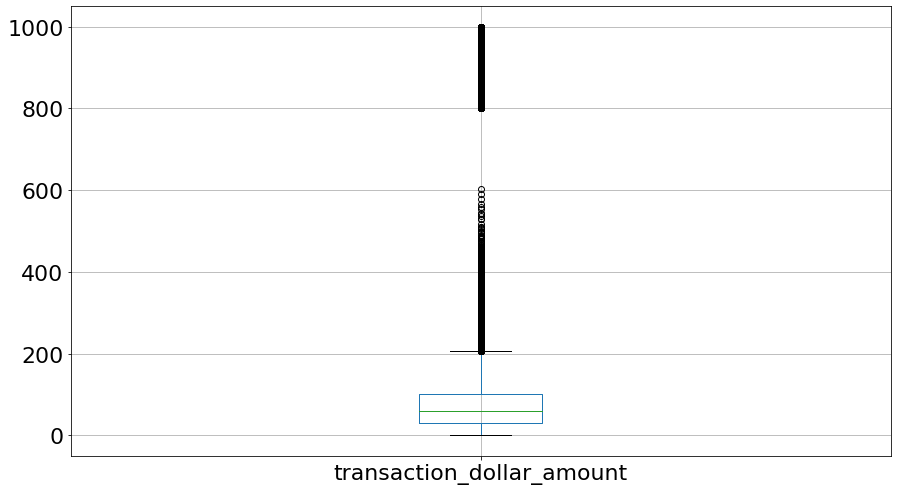

In [18]:
plt.figure(figsize = standard)
df.boxplot(column=['transaction_dollar_amount'])

Any transaction exceeded the 200 is considered outlier in the boxplot. However, this gives us intuition that the transactions between 800 and 1000 should be further investigated as they are not quite a normal behaviour of this data-set.

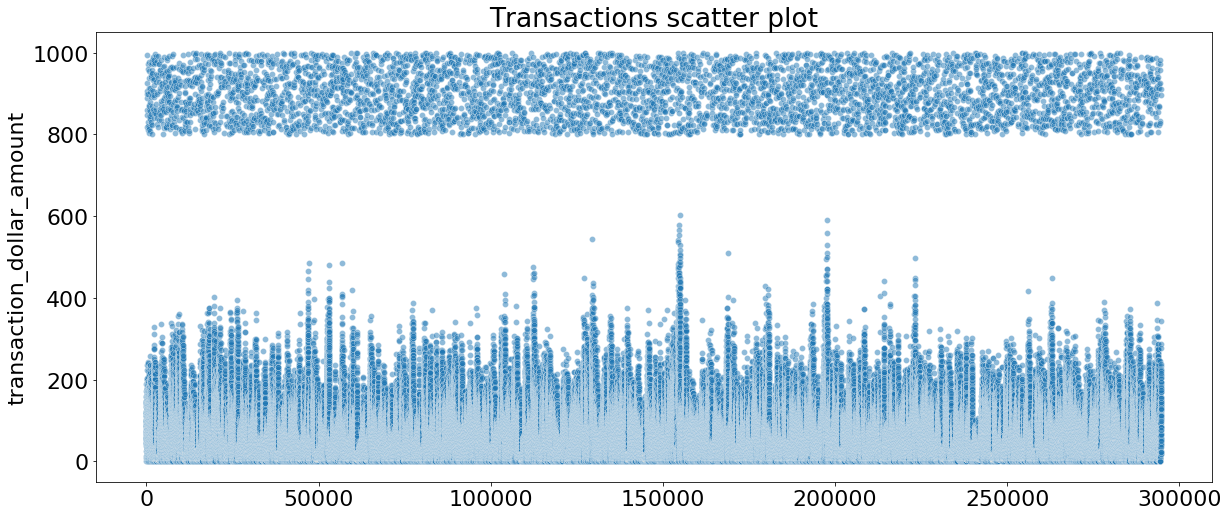

In [19]:
plt.figure(figsize = panorama)
plt.title('Transactions scatter plot')
sb.scatterplot(x = df.index, y = df.transaction_dollar_amount, alpha = 0.5)

In [128]:
df[df['transaction_dollar_amount'] > 700].shape, df.shape

((5455, 7), (294588, 7))

These 5,455 out of 295,588 should be investigated. But let's proceed for other methods.

# Z-score
calculate the Z-score for each transaction. Flag as outlier if it lies out of 3 std from the mean. 

In [111]:
df['global_zscore'] = (df['transaction_dollar_amount'] - df['transaction_dollar_amount'].mean())/df['transaction_dollar_amount'].std(ddof=0)
df.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,global_zscore
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,-0.338757
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,0.137514
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,-0.300492


In [120]:
df["global_zscore_outlier"] = (abs(df["global_zscore"])>3).astype(int)

In [121]:
df_outlier = df.loc[df.global_zscore_outlier == 1]
df_inlier = df.loc[df.global_zscore_outlier == 0]

In [122]:
print(df_outlier.shape[0], " transaction needs further investigation")

5493  transaction needs further investigation


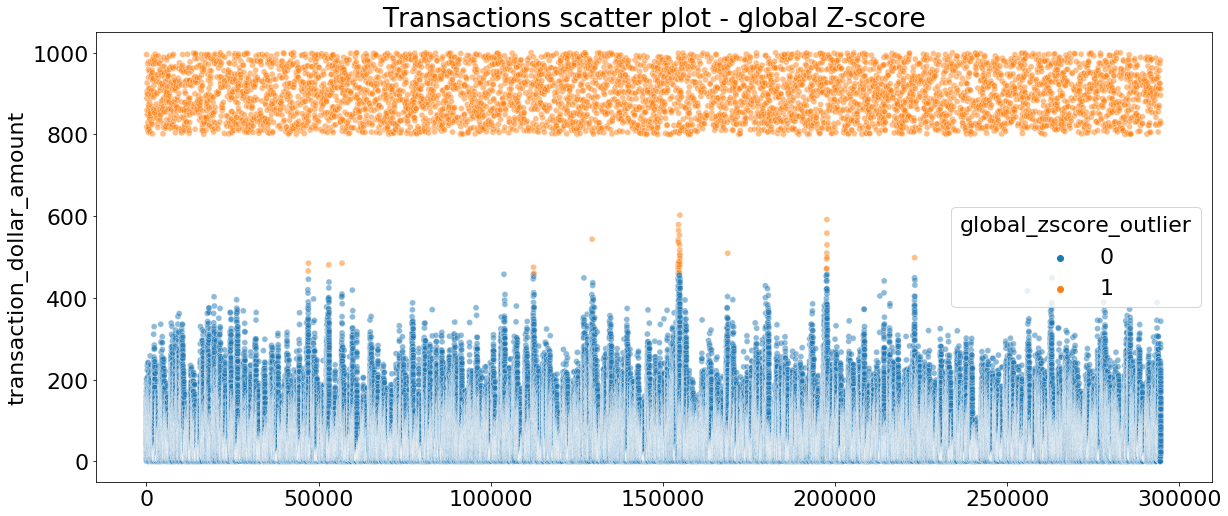

In [123]:
plt.figure(figsize = panorama)
plt.title('Transactions scatter plot - global Z-score')
sb.scatterplot(x = df.index, y = df.transaction_dollar_amount, hue = df.global_zscore_outlier, alpha = 0.5);

The threshold 3 means that  --> 99.7% of the data points lie between +/- 3 standard deviation.
However, we can build a function if we want to investigate other thresholds.




In [117]:
def global_zscore(data, threshold = 3):
    df  = data.copy()
    df['global_zscore'] = (df['transaction_dollar_amount'] - df['transaction_dollar_amount'].mean())/df['transaction_dollar_amount'].std(ddof=0)
    df["global_zscore_outlier"] = (abs(df["global_zscore"])>threshold).astype(int)
    df_outlier = df.loc[df.global_zscore_outlier == 1]
    print(df_outlier.shape[0], " transaction needs further investigation")
    return df

In [118]:
zscore_2 = global_zscore(trans, threshold = 2)
zscore_2.head(3)

5920  transaction needs further investigation


,credit_card,date,transaction_dollar_amount,Long,Lat,global_zscore,global_zscore_outlier
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,-0.338757,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,0.137514,0
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,-0.300492,0


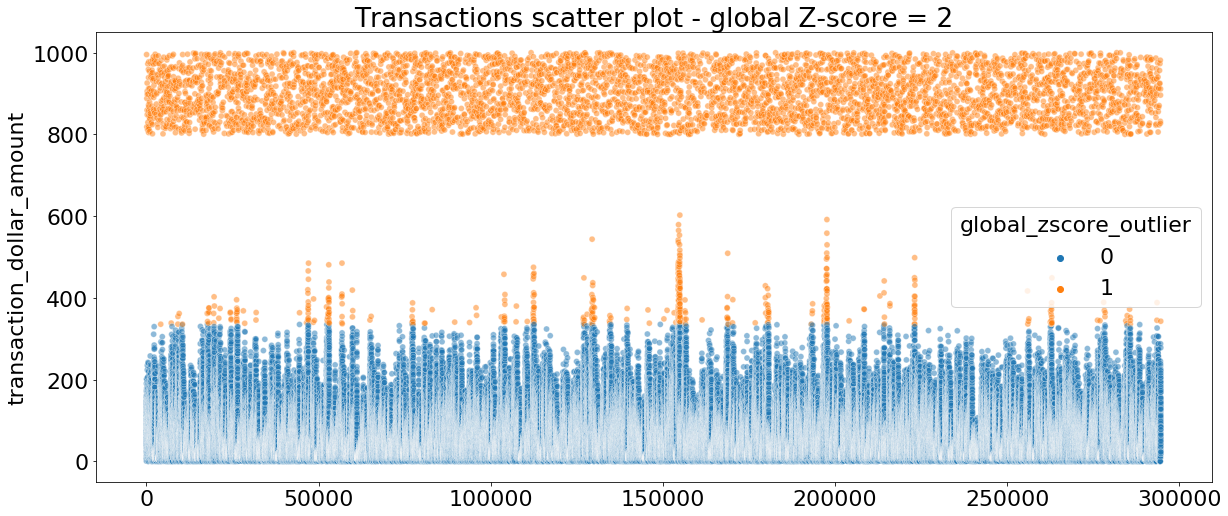

In [119]:
plt.figure(figsize = panorama)
plt.title('Transactions scatter plot - global Z-score = 2')
sb.scatterplot(x = zscore_2.index, y = zscore_2.transaction_dollar_amount, hue = zscore_2.global_zscore_outlier, alpha = 0.5)


fraud numbers increased as z-score of 2 correspond to: 95% of the data points lie between +/- 2 standard deviation

# local Z-score
calculate the z-score for each credit card. I didn't find a reference for this method, but my intuition is that maybe some users have different behaviour in spending their money, and a transaction with high amount will be flaged as inlier. Also, for curiosity: to find out how much different it will be.

In [81]:
trans_mean = pd.pivot_table(df, index=['credit_card'],values=['transaction_dollar_amount'],aggfunc=np.mean).rename(columns={'transaction_dollar_amount':'trans_mean'})
trans_std = pd.pivot_table(df, index=['credit_card'],values=['transaction_dollar_amount'],aggfunc=np.std).rename(columns={'transaction_dollar_amount':'trans_std'})
grouped_data = pd.concat([trans_mean, trans_std],axis=1)
df = pd.merge(
                trans,
                grouped_data,
                how = "inner",
                on = 'credit_card')
df.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,trans_mean,trans_std
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,110.497471,129.120961
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,110.497471,129.120961
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,110.497471,129.120961


In [82]:
df['local_zscore'] = (df['transaction_dollar_amount'] - df['trans_mean']) / df['trans_std']
df.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,trans_mean,trans_std,local_zscore
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,110.497471,129.120961,-0.516705
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,110.497471,129.120961,-0.056904
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,110.497471,129.120961,-0.479763


In [83]:
df["local_zscore_outlier"] = (abs(df["local_zscore"])>3).astype(int)

In [84]:
df_outlier = df.loc[df.local_zscore_outlier == 1]
df_inlier = df.loc[df.local_zscore_outlier == 0]

In [85]:
(df_outlier.shape[0]/df.shape[0])*100 

1.8551332708732196

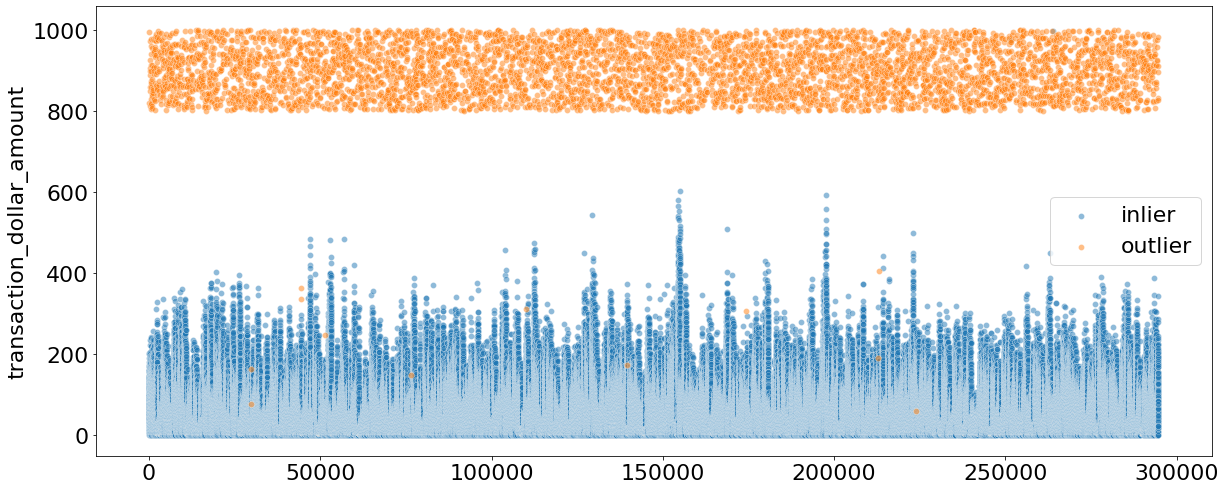

In [86]:
plt.figure(figsize = panorama)

sb.scatterplot(x = df_inlier.index, y = df_inlier.transaction_dollar_amount, alpha = 0.5, label = 'inlier')
sb.scatterplot(x = df_outlier.index, y = df_outlier.transaction_dollar_amount,  alpha = 0.5, label  ='outlier')

As suspected, there will be some differences. There are some transactions that are within 3 std from the global mean but flaged as outlier as they depend on the local mean. Maybe these transaction are worth further investegation.

for example, let's have a quick look for one of the transactions that is less than 400 and flaged as fraud:

In [88]:
df_outlier[df_outlier['transaction_dollar_amount'] < 400 ]

,credit_card,date,transaction_dollar_amount,Long,Lat,trans_mean,trans_std,local_zscore,local_zscore_outlier
29872,1896197396507201,2015-09-11 16:25:49,163.09,-72.083890,43.163364,66.059474,32.076475,3.024975,1
29912,1897978162924096,2015-08-07 21:35:21,77.68,-80.274985,40.189610,29.422906,14.946041,3.228754,1
44484,2290290643257636,2015-10-16 01:33:20,334.97,-74.029587,40.782486,120.505789,69.982408,3.064545,1
44486,2290290643257636,2015-09-26 20:53:04,363.60,-74.057226,40.748339,120.505789,69.982408,3.473647,1
51325,2596862660671371,2015-08-22 03:02:48,246.79,-84.645298,43.444115,95.907414,50.227083,3.004009,1
76512,3424173121597094,2015-08-13 18:12:59,149.81,-81.457861,38.222549,50.793482,27.282357,3.629324,1
110096,4270238553541882,2015-08-27 22:04:27,310.69,-72.027660,43.153370,113.731605,62.377637,3.157516,1
139474,5178912386959057,2015-10-13 21:06:47,174.15,-70.833821,41.831000,67.533642,33.495570,3.182999,1
174395,6126515498577720,2015-09-03 23:10:27,307.22,-72.111962,43.248093,116.397841,61.911418,3.082180,1
212916,7350222978998674,2015-08-23 22:20:24,190.95,-72.552905,42.140964,81.344194,33.864479,3.236601,1


Listing the first credit card transactions and compare visually

In [92]:
df[df['credit_card'] == 1896197396507201]

,credit_card,date,transaction_dollar_amount,Long,Lat,trans_mean,trans_std,local_zscore,local_zscore_outlier
29839,1896197396507201,2015-08-17 20:04:43,75.04,-72.146654,43.233454,66.059474,32.076475,0.279972,0
29840,1896197396507201,2015-09-19 20:32:50,54.45,-72.132658,43.173142,66.059474,32.076475,-0.361931,0
29841,1896197396507201,2015-08-07 00:17:16,64.91,-72.018041,43.188858,66.059474,32.076475,-0.035835,0
29842,1896197396507201,2015-09-02 21:45:44,55.47,-72.025621,43.164852,66.059474,32.076475,-0.330132,0
29843,1896197396507201,2015-09-13 23:19:57,81.32,-72.101521,43.189155,66.059474,32.076475,0.475754,0
29844,1896197396507201,2015-08-20 21:21:51,73.74,-72.077822,43.091829,66.059474,32.076475,0.239444,0
29845,1896197396507201,2015-10-16 15:29:17,86.00,-72.100344,43.133033,66.059474,32.076475,0.621656,0
29846,1896197396507201,2015-08-17 00:11:21,32.12,-72.092085,43.203883,66.059474,32.076475,-1.058080,0
29847,1896197396507201,2015-10-04 21:53:57,33.43,-72.074385,43.199763,66.059474,32.076475,-1.017240,0
29848,1896197396507201,2015-10-02 17:55:16,6.42,-72.088014,43.085255,66.059474,32.076475,-1.859290,0
